In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/caoxiaowen/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-11-28'
to_date = '2021-12-12'
connection_string = 'sqlite:///data/data.db'

In [3]:
# Parameters
from_date = "2021-11-28 00:00:00"
to_date = "2021-12-12 00:00:00"
token = "USDT"
connection_string = "sqlite:///data/data.db"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])
prices.set_index('ts', inplace=True)

In [5]:
def h_ret(df):
    return df.assign(h_ret=np.log(df.close/df.close.shift(1)))

def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return df.assign(volatility=result)

def max_drawdown(df):
    MDD = 0
    MDD_s = pd.Series(dtype='float64')
    start = df.index[0]
    
    for i in df.index:
        max_close = max(df.loc[start:i,'close'])
        DD = (df.loc[i,'close']-max_close)/max_close
        if DD < MDD:
            MDD = DD
        MDD_s.loc[i] = MDD   
        
    return df.assign(MDD=MDD_s)

prices = h_ret(prices)
prices = vol_ohlc(prices)
prices = max_drawdown(prices)

In [6]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [7]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

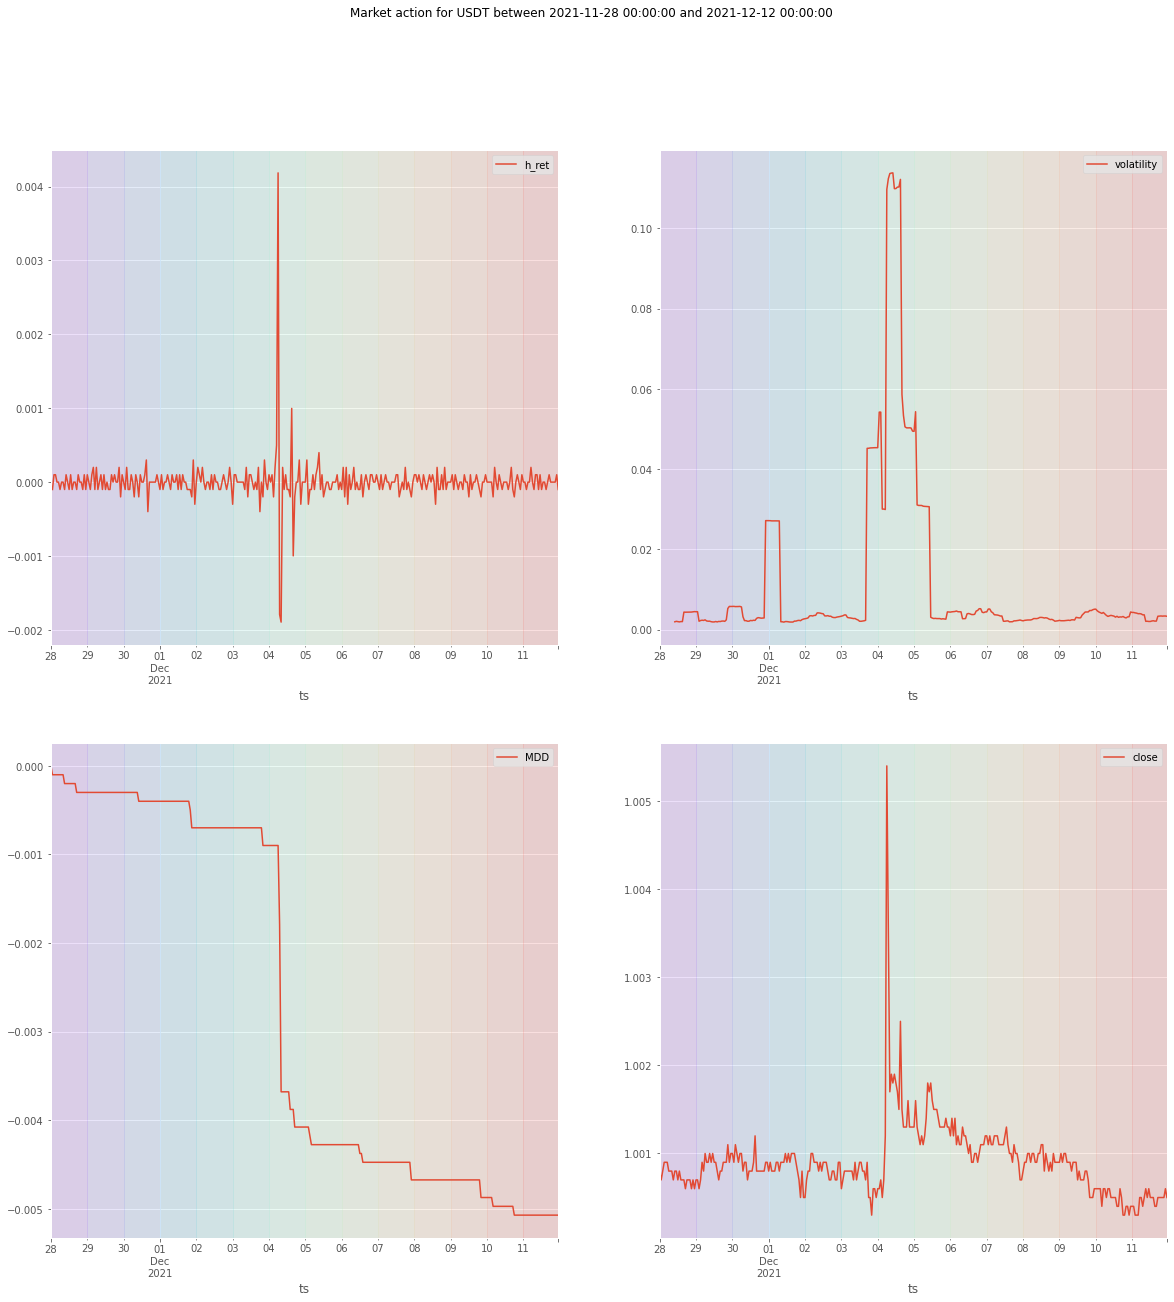

In [8]:
series_plot(prices[['h_ret']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['MDD']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

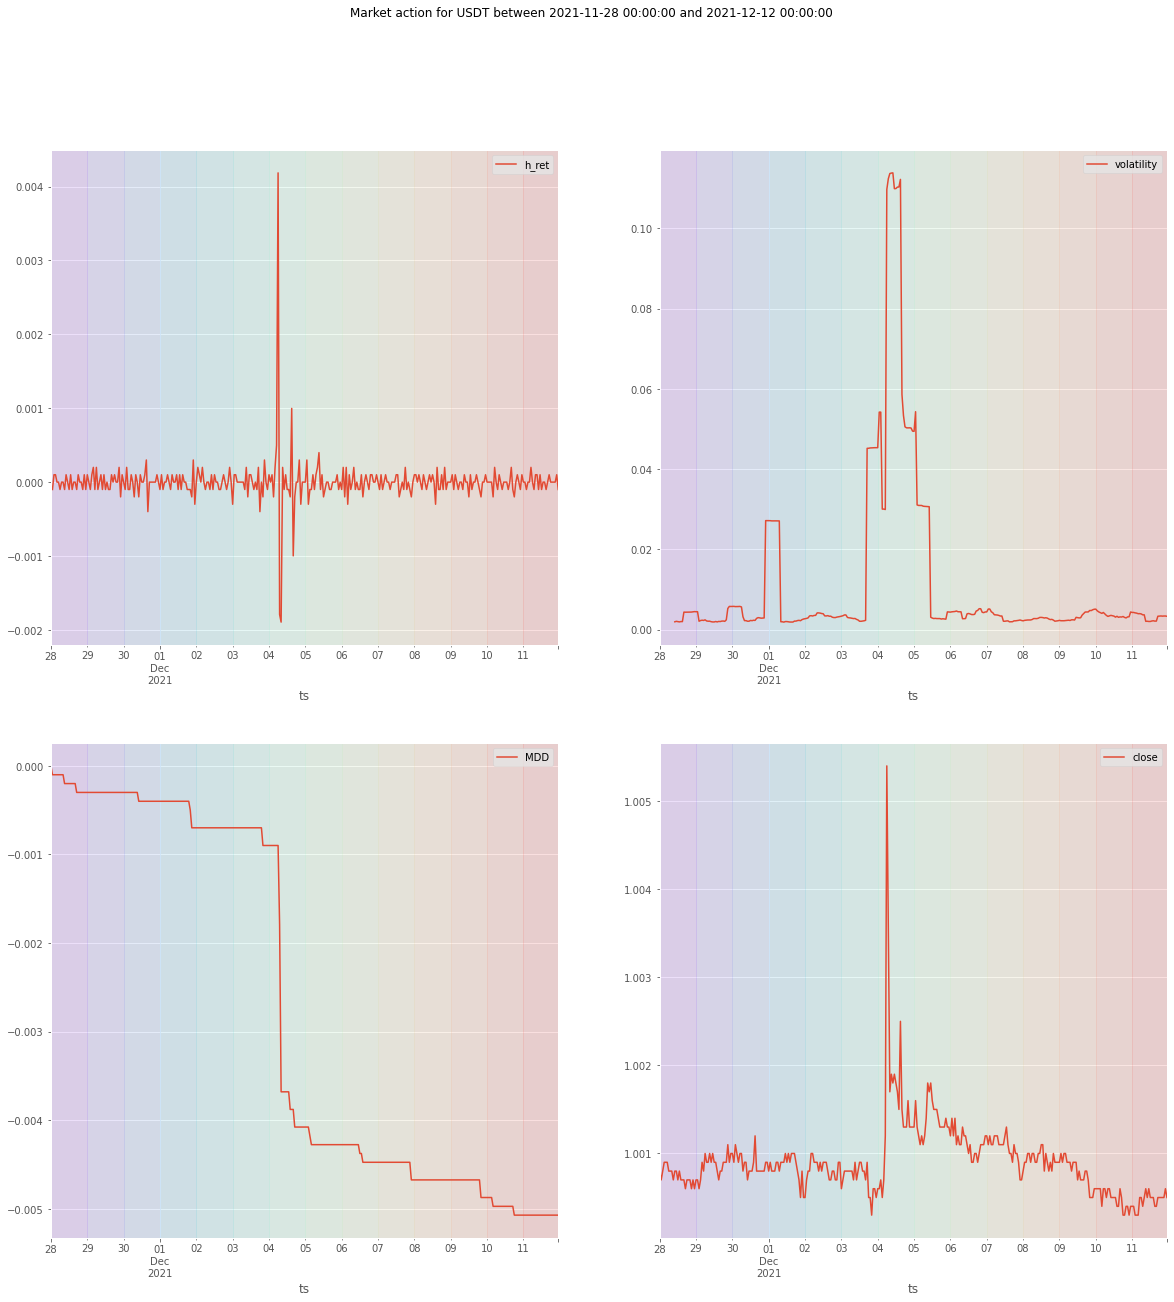

In [9]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)

In [10]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,h_ret,volatility,MDD
ts,,,,,,,,,,,
2021-11-28 00:00:00,1.0007,1.0009,1.0007,1.0008,2898788.02,2.901094e+06,USDT,USDT,NaN,NaN,0.000000
2021-11-28 01:00:00,1.0008,1.0008,1.0006,1.0007,1677656.48,1.678801e+06,USDT,USDT,-0.0001,NaN,-0.000100
2021-11-28 02:00:00,1.0006,1.0008,1.0006,1.0008,2025630.12,2.027171e+06,USDT,USDT,0.0001,NaN,-0.000100
2021-11-28 03:00:00,1.0007,1.0009,1.0007,1.0009,3033288.52,3.035680e+06,USDT,USDT,0.0001,NaN,-0.000100
2021-11-28 04:00:00,1.0009,1.0010,1.0008,1.0009,2880595.56,2.883123e+06,USDT,USDT,0.0000,NaN,-0.000100
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11 19:00:00,1.0005,1.0005,1.0004,1.0005,1638091.57,1.638874e+06,USDT,USDT,0.0000,0.003390,-0.005073
2021-12-11 20:00:00,1.0005,1.0005,1.0004,1.0005,1789709.35,1.790561e+06,USDT,USDT,0.0000,0.003348,-0.005073
2021-12-11 21:00:00,1.0004,1.0006,1.0004,1.0005,1502017.57,1.502792e+06,USDT,USDT,0.0000,0.003379,-0.005073
